# Gym environment for a High Contrast Imaging instrument's AO control system.

## Attributes:
This is a simplified HCI system environment. The dynamics of the environment is based on a Markov Decision Process. The relevant attributes are the "state", "action", "reward".  
The state in this case consists of 2 channels. The first is the WFS recorded phase projected on the DM actuator mode basis. For example, with a 25x25 actuator DM the state is a 25x25 matrix of actuator values. The second is the current DM actuator amplitudes. So overall, the state is a 25x25x2 tensor.   
The action is the actuator amplitudes to be applied on the DM for the current timestep. In the case of a DM with 25x25 actuators, it is simply a 25x25 matrix.    
The reward is a single scalar value. We can use the Strehl, the contrast, or any other such metric that needs to be maximized through AO control.  

## Description:
1. The optical system is defined in a class that inherits from OpenAI's gym environment class.
2. This class contains 3 main methods - \_\_init\_\_(...), step(...), reset(...).
3. The \_\_init\_\_(...) method sets up the optical system with the following components in order: a turbulence generator, a demagnifier, a DM, a WFS, a coronagraph, a quasi-static NCPA aberration, and a detector.
4. The step(action) function does the following:
   * The DM is updated with the actuator values specified in the "action".
   * The wavefront is propagated through the science optical path.
   * The instantaneous focal plane image is calculated.
   * A reward is calculated using the metric function on the focal plane image, and is used to update the reward variable.
   * The timestep is incremented by 1, and the turbulence generator is evolved accordingly.
   * The WFS measurement is read out. The state variable for WFS measurement is updated.
5. A reinforcement learning algorithm works in this environment to maximize expected future reward.

### Step 0: ONLY RUN THIS ON COLAB!

In [ ]:
!pip uninstall hcipy
!rm -rf hcipy
!git clone https://github.com/ehpor/hcipy.git
!cd hcipy; git pull
!cd hcipy; python setup.py install

!mkdir agents
!mkdir models
!mkdir envs
!mkdir utils
!mkdir coronagraphs

!mv agent.py agents/.
!mv model.py models/.
!mv HCI_TestBench.py envs/.
!mv noise_model.py utils/.
!mv replay_buffer.py utils/.
!mv *.fits coronagraphs/.

Now restart the kernel before running the next cell.

### Step 1: Importing necessary libraries.

In [1]:
# Necessary imports
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from hcipy import *
import matplotlib.pyplot as plt
from astropy.io import fits
import os, glob
import time
import tensorflow as tf

In [2]:
from envs.HCI_TestBench_residual import HCI_TestBench

app_amp_file = "coronagraphs/Square_20_80_20_25_0_2_amp_resampled_256.fits"
app_phase_file = "coronagraphs/Square_20_80_20_25_0_2_phase_resampled_256.fits"

### Step 2: Define testbench parameters.

In [3]:
# Create aperture and pupil/focal grids
wavelength = 532e-9
N = 256
D = 10.5e-3
pupil_grid = make_pupil_grid(N, D)
science_focal_grid = make_focal_grid(8, 20, wavelength/D)
aperture = circular_aperture(D)
oversized_aperture = circular_aperture(D*1.01)

# Telescope parameters
Dtel = 4
tel_pupil_grid = make_pupil_grid(N, Dtel)
tel_aperture = circular_aperture(Dtel)

# Create the deformable mirror
num_actuators = 25
actuator_spacing = D * 1.1 / num_actuators
xinetics_basis = make_xinetics_influence_functions(pupil_grid, num_actuators, actuator_spacing)
dm = DeformableMirror(xinetics_basis)
num_modes = len(dm.influence_functions)
dm.actuators = np.zeros(num_modes)

# Create a mask for the usable actuators
positions = make_actuator_positions(num_actuators, actuator_spacing)
mask = oversized_aperture(positions)

## Create the Shack-Hartmann wavefront sensor and estimator
## Create the microlens array
F_mla = 30. / 0.3
N_mla = 32
D_mla = 10.5e-3

shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid, F_mla, N_mla, D_mla)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index, circular_aperture(D)(shwfs.mla_grid).astype('bool'))

# Atmosphere parameters
velocity = 10 #m/s
L0 = 40 # outer scale
r0 = 0.2 # Fried parameter
height = 0 # layer height
timestep = 1e-3 # 1 ms per phasescreen

# Make atmosphere
layers = []
layer = InfiniteAtmosphericLayer(tel_pupil_grid, Cn_squared_from_fried_parameter(r0, 500e-9), L0, velocity, height, stencil_length=2, use_interpolation=True)
layers.append(layer)
atmosphere = MultiLayerAtmosphere(layers, False)

# Atmosphere parameters
#pixels_per_frame = 1
#velocity = np.array([pixels_per_frame,0])
#L0 = 40
#r0 = 0.2
#height = 0

# Make atmosphere
#layers = []
#layer = InfiniteAtmosphericLayer(tel_pupil_grid, Cn_squared_from_fried_parameter(r0, 500e-9), L0, velocity * tel_pupil_grid.delta[0], height, 2)
#layers.append(layer)
#atmosphere = MultiLayerAtmosphere(layers, False)

## Create a demagnifier
demag = Magnifier(D / Dtel)

# Make initial phasescreen
wf_tel = Wavefront(tel_aperture(tel_pupil_grid), wavelength)
wf_tel.total_power = 100000
wf = demag.forward(wf_tel)

## Create propagator from pupil to focal plane
prop = FraunhoferPropagator(pupil_grid, science_focal_grid)

## Get the app coronagraph
app_amp = fits.getdata(app_amp_file).ravel()
app_phase = fits.getdata(app_phase_file).ravel()
app = Apodizer(app_amp * np.exp(1j * app_phase))

# For now we don't use a coronagraph so make it just a flat phase
app = Apodizer(np.exp(1j * np.zeros(wf.phase.shape)))

## Create detector
science_camera = NoiselessDetector()

## Generate a diffraction limited image for metrics
diff_lim_img = prop(wf).power

## Get the unit lambda/D
l_D = wavelength / D
plot_grid = make_focal_grid(8, 20, 1)

## Create a noiseless camera image from the perfectly flat wavefront with coronograph
wfdm = dm.forward(wf)
wfapp = app.forward(wfdm)
imapp = prop(wfapp).power
dz_ind = np.where((imapp.grid.x >= (2 * l_D)) &\
                  (imapp.grid.x <= (8 * l_D)) &\
                  (imapp.grid.y >= (-3 * l_D)) &\
                  (imapp.grid.y <= (3 * l_D)))

## Create an NCP aberration
num_coeffs = 9
plaw_index = -1
np.random.seed(7)
coeffs = ((np.random.rand(num_coeffs) - 0.5) * 2) * (np.arange(num_coeffs, dtype=float) + 1) ** plaw_index
coeffs = np.zeros(coeffs.shape) # Set NCP to zero for now
zernike_basis = make_zernike_basis(num_coeffs, D, pupil_grid, 2)
ncp_phase = np.dot(zernike_basis.transformation_matrix, coeffs)
ncp = Apodizer(np.exp(1j * ncp_phase))

# Create an estimate of the NCP aberration for the forward model
ncp_field_est = np.exp(1j * np.zeros(app_phase.shape))
estimated_coeffs = np.zeros(coeffs.shape)

In [4]:
tb = HCI_TestBench(wf_tel, timestep, atmosphere, demag, dm, mask, shwfs, shwfse, ncp, app, prop, science_camera, dz_ind, "strehl")

Loading pre-calibrated control matrix


/home/vikram/miniconda3/envs/ai_esports/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Step 3: See a standard linear controller in action
In this section we will simply add the wavefront sensor measurement with the current DM actuator values. This should give a reasonably high Strehl / contrast. This is just to see that the testbench works as expected.

In [ ]:
state = tb.reset() # Start with a new phasescreen

for time in range(50):
    
    amps = state.copy()
    amps = np.squeeze(amps)
    amps = np.clip(amps, -1, 1)
    
    recon_wf = tb._dm.forward(tb._turbulence())
    imshow_field(recon_wf.phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
    plt.show()
    
    next_state, reward, done, _ = tb.step(amps)
    
    
    state = next_state.copy()
    
    print("\rTime step: {} Strehl ratio: {:.3f}".format(time, reward), end="")

So with a simple addition operation the resulting Strehl is quite good, between 78 to 80 percent. We should be able to reproduce this with a well trained agent.

### Step 4: Train the DDPG agent

In [5]:
from agents.agent import DDPG
from collections import deque

In [6]:
# Define all hyperparameters here
ACTOR_LR = 1e-5
CRITIC_LR = 1e-3
RANDOM_SEED = 42
MU = 0.0
THETA = 0.15
SIGMA = 1.0
BUFFER_SIZE = 10000
BATCH_SIZE = 64
GAMMA = 0.95
TAU = 1e-2
N_TIME_STEPS = 1
N_LEARN_UPDATES = 1
EPSILON_START = 1
EPSILON_DECAY = 1
EPSILON_END = 1

if tf.test.is_gpu_available():
    DEVICE = "/GPU:0"
else:
    DEVICE = "/device:CPU:0"

In [7]:
state_size = (25, 25, 1)
action_size = (25, 25, 1)

In [8]:
agent = DDPG(state_size, action_size, ACTOR_LR, CRITIC_LR,
             RANDOM_SEED, MU, THETA, SIGMA, BUFFER_SIZE, BATCH_SIZE,
             EPSILON_START, EPSILON_END, EPSILON_DECAY,
             GAMMA, TAU, N_TIME_STEPS, N_LEARN_UPDATES, DEVICE)

Episode 1 Time in ms:300 Average Strehl: 0.011
Episode 2 Time in ms:256 Average Strehl: 0.006
Episode 3 Time in ms:295 Average Strehl: 0.006
Episode 4 Time in ms:280 Average Strehl: 0.005
Episode 5 Time in ms:213 Average Strehl: 0.009
Episode 6 Time in ms:165 Average Strehl: 0.010
Episode 7 Time in ms:111 Average Strehl: 0.007
Episode 8 Time in ms:102 Average Strehl: 0.008
Episode 9 Time in ms:128 Average Strehl: 0.011
Episode 10 Time in ms:84 Average Strehl: 0.010
Episode 11 Time in ms:121 Average Strehl: 0.018
Episode 12 Time in ms:130 Average Strehl: 0.009
Episode 13 Time in ms:93 Average Strehl: 0.010
Episode 14 Time in ms:111 Average Strehl: 0.009
Episode 15 Time in ms:80 Average Strehl: 0.007
Episode 16 Time in ms:69 Average Strehl: 0.013
Episode 17 Time in ms:92 Average Strehl: 0.019
Episode 18 Time in ms:83 Average Strehl: 0.006
Episode 19 Time in ms:111 Average Strehl: 0.007
Episode 20 Time in ms:117 Average Strehl: 0.007
Episode 21 Time in ms:68 Average Strehl: 0.007
Episode 

Episode 173 Time in ms:56 Average Strehl: 0.008
Episode 174 Time in ms:50 Average Strehl: 0.016
Episode 175 Time in ms:51 Average Strehl: 0.009
Episode 176 Time in ms:41 Average Strehl: 0.008
Episode 177 Time in ms:55 Average Strehl: 0.015
Episode 178 Time in ms:52 Average Strehl: 0.008
Episode 179 Time in ms:56 Average Strehl: 0.011
Episode 180 Time in ms:44 Average Strehl: 0.010
Episode 181 Time in ms:50 Average Strehl: 0.018
Episode 182 Time in ms:48 Average Strehl: 0.009
Episode 183 Time in ms:45 Average Strehl: 0.011
Episode 184 Time in ms:52 Average Strehl: 0.014
Episode 185 Time in ms:45 Average Strehl: 0.015
Episode 186 Time in ms:63 Average Strehl: 0.027
Episode 187 Time in ms:43 Average Strehl: 0.010
Episode 188 Time in ms:59 Average Strehl: 0.016
Episode 189 Time in ms:48 Average Strehl: 0.014
Episode 190 Time in ms:46 Average Strehl: 0.020
Episode 191 Time in ms:58 Average Strehl: 0.023
Episode 192 Time in ms:63 Average Strehl: 0.018
Episode 193 Time in ms:69 Average Strehl

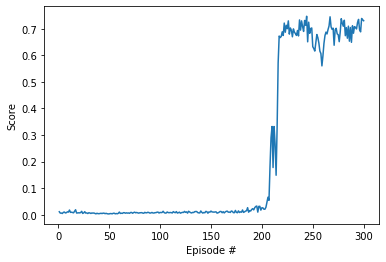

In [9]:
def ddpg(n_episodes=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        state = tb.reset()
        agent.reset()
        score = 0
        t = 0
        
        while(t < 300):
            t += 1
            action = agent.act(state)
            
            next_state, reward, done, _ = tb.step(np.squeeze(action))
            
            #if t == 300:
                #done = True
            
            agent.step(t, state, action, -np.log10(1 - reward), next_state, done)
            
            state = next_state.copy()
            score += reward
            
            print('\rEpisode {} Time in ms:{} Score: {:.3f}'.format(i_episode, t, reward), end="")
            
            if done:
                break
                
        scores_deque.append(score / t)
        scores.append(score / t)
        agent.actor_local.model.save('checkpoint_actor.h5')
        agent.critic_local.model.save('checkpoint_critic.h5')
        print('\rEpisode {} Time in ms:{} Average Strehl: {:.3f}'.format(i_episode, t, (score / t)))
        
        if np.mean(scores_deque) >= 0.8:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode-100, np.mean(scores_deque)))
            agent.actor_local.model.save('checkpoint_actor.h5')
            agent.critic_local.model.save('checkpoint_critic.h5')
            break

    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
plt.imshow(np.squeeze(tb.state))
plt.colorbar()

### Step 5: Watch a trained agent in action

In [10]:
n_episodes = 1

for i_episode in range(1, n_episodes+1):
    state = tb.reset()
    score = 0
    t = 0
        
    while(t < 300):
        t += 1
        state = np.expand_dims(state, 0)
        action = agent.actor_local.model(state)
        action = action.numpy()[0]
        next_state, reward, done, _ = tb.step(action)
        print('\rTime in ms:{}\t Strehl: {:.2f}'.format(t, reward), end="")
        state = next_state
        score += reward
        
        if done:
            break
        
print("\nAverage Strehl is: {:.2f}".format(score/t))

Time in ms:300	 Strehl: 0.73Average Strehl is: 0.75


### Step 6: Train the agent now to maximize contrast

In [21]:
app = Apodizer(app_amp * np.exp(1j * app_phase))

tb_contrast = HCI_TestBench(wf_tel, timestep, atmosphere, demag, dm, mask, shwfs, shwfse, ncp, app, prop, science_camera, dz_ind, rwrd_func="contrast")

Loading pre-calibrated control matrix


/home/vikram/miniconda3/envs/ai_esports/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float64
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [23]:
n_episodes = 1

for i_episode in range(1, n_episodes+1):
    state = tb_contrast.reset()
    score = 0
    t = 0
        
    while(t < 300):
        t += 1
        state = np.expand_dims(state, 0)
        action = agent.actor_local.model(state)
        action = action.numpy()[0]
        next_state, reward, done, _ = tb_contrast.step(action)
        print('\rTime in ms:{}\t Log contrast: {:.2f}'.format(t, reward), end="")
        state = next_state
        score += reward
        
        if done:
            break
        
print("\nAverage log contrast is: {:.2f}".format(score/t))

Time in ms:300	 Log contrast: 3.93
Average log contrast is: 3.60


In [30]:
ACTOR_LR = 1e-7
CRITIC_LR = 1e-3
EPSILON_START = 1
EPSILON_END = 1e-3

agent_contrast = DDPG(state_size, action_size, ACTOR_LR, CRITIC_LR,
                      RANDOM_SEED, MU, THETA, SIGMA, BUFFER_SIZE, BATCH_SIZE,
                      EPSILON_START, EPSILON_END, EPSILON_DECAY,
                      GAMMA, TAU, N_TIME_STEPS, N_LEARN_UPDATES, DEVICE)

In [34]:
agent_contrast.actor_local.model.summary()

Model: "Actor_local"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 25, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 1)         73        
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [31]:
agent_contrast.actor_local.model.set_weights(agent.actor_local.model.get_weights())
agent_contrast.actor_target.model.set_weights(agent.actor_local.model.get_weights())

In [32]:
def contrast_ctrl(n_episodes=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        state = tb_contrast.reset()
        agent.reset()
        score = 0
        t = 0
        
        while(t < 300):
            t += 1
            action = agent_contrast.act(state)
            next_state, reward, done, _ = tb_contrast.step(np.squeeze(action))
            
            
            agent_contrast.step(t, state, action, reward**2, next_state, done)
            state = next_state.copy()
            score += reward
            
            print('\rEpisode {} Time in ms:{}\t Contrast: {:.2f}'.format(i_episode, t, reward), end="")
            
            if t == 300:
                done = True
                
            if done:
                break
                
        scores_deque.append(score / t)
        scores.append(score / t)
        agent_contrast.actor_local.model.save('ctrst_actor.h5')
        agent_contrast.critic_local.model.save('ctrst_critic.h5')
        print('\rEpisode {} Time in ms:{} Average Contrast: {:.3f}'.format(i_episode, t, (score / t)))
        
        if np.mean(scores_deque) >= 7:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            agent_contrast.actor_local.model.save('cntrst_actor.h5')
            agent_contrast.critic_local.model.save('cntrst_critic.h5')
            break
            
    return scores


scores = contrast_ctrl()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('log10 Contrast')
plt.xlabel('Episode #')
plt.show()

Episode 1 Time in ms:300 Average Contrast: 3.369
Episode 2 Time in ms:300 Average Contrast: 3.457
Episode 3 Time in ms:300 Average Contrast: 3.422
Episode 4 Time in ms:300 Average Contrast: 3.426
Episode 5 Time in ms:300 Average Contrast: 3.387
Episode 6 Time in ms:300 Average Contrast: 3.396
Episode 7 Time in ms:300 Average Contrast: 3.341
Episode 8 Time in ms:300 Average Contrast: 3.422
Episode 9 Time in ms:300 Average Contrast: 3.486
Episode 10 Time in ms:300 Average Contrast: 3.276
Episode 11 Time in ms:300 Average Contrast: 3.353
Episode 12 Time in ms:300 Average Contrast: 3.421
Episode 13 Time in ms:300 Average Contrast: 3.425
Episode 14 Time in ms:300 Average Contrast: 3.493
Episode 15 Time in ms:300 Average Contrast: 3.406
Episode 16 Time in ms:300 Average Contrast: 3.392
Episode 17 Time in ms:300 Average Contrast: 3.404
Episode 18 Time in ms:300 Average Contrast: 3.503
Episode 19 Time in ms:300 Average Contrast: 3.399
Episode 20 Time in ms:300 Average Contrast: 3.324
Episode 2

KeyboardInterrupt: 

In [ ]:
imshow_field(np.log10(tb_contrast._img / tb_contrast._img.max()), vmin=-4, grid=plot_grid)

In [ ]:
state = tb_contrast.reset()
state = np.expand_dims(state, 0)
action = agent_contrast.actor_local.model(state)
action = action.numpy()[0]
#action = state[:, :, 0].copy() + state[:, :, 1].copy()
#action = np.clip(action, -1, 1)
next_state, reward, done, _ = tb_contrast.step(action.squeeze())

reward